# Project 2
**Name**: Adriane Mikko Amorado<br>
**Course Name**: Solving Business Problems with NLP<br>
**Instructor**: Juber Rahman

## Imports

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

import gensim
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Analysis

### 1. Select a book of your choice from project Gutenberg https://www.gutenberg.org/

In [2]:
url = 'https://www.gutenberg.org/files/15420/15420.txt'

### 2. Load the text in your python workspace

In [3]:
data = requests.get(url)

### 3. Do topic modeling on the text after due preprocessing, vectorization etc.

In [4]:
def data2docs(data):
    docs = pd.Series([doc.strip() for doc in data.text.split('\r\n\r\n') if doc])
    start = docs.index[docs.str.startswith('*** START OF THIS PROJECT GUTENBERG EBOOK')]
    end = docs.index[docs.str.startswith('*** END OF THIS PROJECT GUTENBERG EBOOK')]
    return docs.loc[start[0]+1: end[0]-1]

In [5]:
docs = data2docs(data)

In [6]:
def tokenizer(doc):
    """Tokenizes docs by applying pos with lemmatizer for each token"""
    tokenizer = RegexpTokenizer(r'(?u)\b(\w(?:\w|\-)+)\b')
    tokens = tokenizer.tokenize(doc)

    postags = [
        (token.lower(), 'a' if pos[0] == 'J' else pos[0].lower())
        for token, pos in nltk.pos_tag(tokens)
        if pos[0] in 'JNVR']
    
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(*t) for t in postags]

    return lemmas

In [7]:
bow_pipeline = Pipeline(
    [
        ("bow", CountVectorizer(
            tokenizer=tokenizer,
            stop_words=stopwords.words('english')
        )),
        ("lda", LatentDirichletAllocation(
            n_components=5,             
            max_iter=10,             
            learning_method='online',
            random_state=100,        
            batch_size=128,          
            evaluate_every=-1,     
            n_jobs = -1
        )),
    ]
)

In [8]:
bow_pipeline.fit(docs)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('bow',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function tokenizer at 0x7f214b52a560>)),
                ('lda',
                 LatentDirichletAllocation(learning_method='online',
                                           n_components=5, n_jobs=-1,
                                           random_state=100))])

In [9]:
# Log Likelihood: Higher the better
print("Log Likelihood: ", bow_pipeline.score(docs))

# Perplexity: Lower the better. 
print("Perplexity: ", bow_pipeline['lda'].perplexity(bow_pipeline['bow'].transform(docs)))

Log Likelihood:  -146026.15554281248
Perplexity:  1978.534148551787


In [10]:
tfidf_pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer(
            tokenizer=tokenizer,
            stop_words=stopwords.words('english')
        )),
        ("lda", LatentDirichletAllocation(
            n_components=5,             
            max_iter=10,             
            learning_method='online',
            random_state=100,        
            batch_size=128,          
            evaluate_every=-1,     
            n_jobs = -1
        )),
    ]
)

In [11]:
tfidf_pipeline.fit(docs)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  % sorted(inconsistent)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function tokenizer at 0x7f214b52a560>)),
                ('lda',
                 LatentDirichletAllocation(learning_method='online',
                                           n_components=5, n_jobs=-1,
                                           random_state=100))])

In [12]:
# Log Likelihood: Higher the better
print("Log Likelihood: ", tfidf_pipeline.score(docs))

# Perplexity: Lower the better. 
print("Perplexity: ", tfidf_pipeline['lda'].perplexity(tfidf_pipeline['tfidf'].transform(docs)))

Log Likelihood:  -25222.619218228218
Perplexity:  11524.04667413381


### 4. How many topics are there, what are they?

In [13]:
pip install pyLDAvis

In [14]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(
    bow_pipeline['lda'],
    bow_pipeline['bow'].transform(docs),
    bow_pipeline['bow'], 
    mds='tsne')
panel

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      150.222153  -72.269554       1        1  52.668129
0       51.163364 -159.968018       2        1  18.489188
2      -73.144554   21.523815       3        1  14.156126
1      -66.410133 -110.606438       4        1  12.810701
4       54.417324   12.443444       5        1   1.875856, topic_info=           Term        Freq       Total Category  logprob  loglift
3155     social  153.000000  153.000000  Default  30.0000  30.0000
2175   marriage   75.000000   75.000000  Default  29.0000  29.0000
888       court  147.000000  147.000000  Default  28.0000  28.0000
3226      state   65.000000   65.000000  Default  27.0000  27.0000
1020  desertion  152.000000  152.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1401    failure    0.582447   12.010691   Topic5  -6.4291   0.9498
1765        ill    0.520338    8.099046   Topic5  -6.5419   1.2311
3257      story    0.621198   32.824032   Topic5  -6.3647   0.0088
3715       well    0.626346   48.282468   Topic5  -6.3564  -0.3688
3085        sex    0.554879   27.740213   Topic5  -6.4776   0.0642

[344 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         4  0.943423  101-102
24        2  0.927712  139-140
54        4  0.764057  193-199
61        2  0.937530    25-26
67        4  0.896021    34-35
...     ...       ...      ...
3793      4  0.099341     year
3800      1  0.116781     york
3800      2  0.029195     york
3800      3  0.087586     york
3800      4  0.759079     york

[523 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2, 5])

### 5. Which vectorization method performed better?

In [15]:
scores = [
    {
        'method': 'BoW',
        'Log Likelihood': bow_pipeline.score(docs),
        'Perplexity': bow_pipeline['lda'].perplexity(bow_pipeline['bow'].transform(docs))
    },
    {
        'method': 'TF-IDF',
        'Log Likelihood': tfidf_pipeline.score(docs),
        'Perplexity': tfidf_pipeline['lda'].perplexity(tfidf_pipeline['tfidf'].transform(docs))
    }
]
pd.DataFrame.from_records(scores)

,method,Log Likelihood,Perplexity
0,BoW,-146026.155543,1978.534149
1,TF-IDF,-25222.619218,11524.046674


In terms of `Log Likelihood`, TF-IDF is better (higher value), but in terms of `Perplexity`, TF-IDF is worse (higher vlaue).

### 6. Compare the results with different topic classification models.

In [16]:
def evaluate_method(model, name, docs):
    model = Pipeline([
        ('vectorizer', TfidfVectorizer(
            tokenizer=tokenizer,
            stop_words=stopwords.words('english')
        )),
        ("lda", model)
    ])
    model.fit(docs)
    return {
        'method': name,
        'Log Likelihood': model.score(docs),
        'Perplexity': model['topic_model'].perplexity(model['vectorizer'].transform(docs))
    }

In [21]:
def get_coherence(model, texts, dictionary):
    """
    Get coherence score from model.
    """
    coherence_model = CoherenceModel(
        model=model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return coherence_model.get_coherence()

In [22]:
def get_model(model, corpus, id2word):
    """
    Construct model using `gensim` topic model classes
    """
    return model(
        corpus=corpus,
        id2word=id2word,
        num_topics=5,
        chunksize=100
    )

In [23]:
def get_score(model, pipe):
    """
    Evaluate methods and pipelines
    """
    tokens=[
        list(token)
        for token
        in pipe['bow'].inverse_transform(pipe['bow'].transform(docs))
    ]
    id2word = gensim.corpora.Dictionary(tokens)
    corpus = [id2word.doc2bow(token) for token in tokens]
    return get_coherence(
        model=get_model(
            model=model,
            corpus=corpus,
            id2word=id2word),
        texts=tokens,
        dictionary=id2word,
    )

In [27]:
models = {
    'LDA': gensim.models.ldamodel.LdaModel,
    'NMF': gensim.models.nmf.Nmf,
    'LSA': gensim.models.lsimodel.LsiModel
}
res = [
    {
        'Model': name,
        'Coherence Score': get_score(module, bow_pipeline)
    }
    for name, module in models.items()
]

In [26]:
pd.DataFrame.from_records(res)

,Model,Coherence Score
0,LDA,0.365173
1,NMF,0.648223
2,LSA,0.698994


### 7. (optional) use random search or grid search to optimize the number of topics.

In [45]:
gs = GridSearchCV(
    tfidf_pipeline,
    param_grid={
        'lda__n_components': [3, 4, 5, 6]
    }
)

gs.fit(docs)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  % sorted(inconsistent)
/usr/loc

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                    

In [46]:
gs.best_params_

{'lda__n_components': 3}

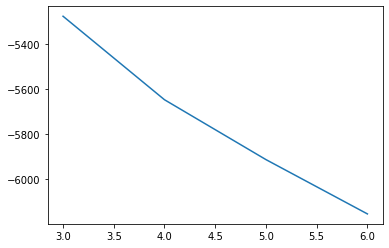

In [47]:
plt.plot(
    gs.cv_results_['param_lda__n_components'].data,
    gs.cv_results_['mean_test_score']
)

In [37]:
gs.cv_results_

{'mean_fit_time': array([3.14027996, 3.03638988, 3.09495401, 3.27594309, 3.42959924,
        3.58529329]),
 'mean_score_time': array([0.46489363, 0.44774923, 0.45874119, 0.46287751, 0.45386505,
        0.46877632]),
 'mean_test_score': array([ -5912.25391374,  -7282.86757851,  -8142.04570777,  -9242.12323519,
        -10557.48635448, -11704.81409571]),
 'param_lda__n_components': masked_array(data=[5, 10, 15, 20, 25, 30],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lda__n_components': 5},
  {'lda__n_components': 10},
  {'lda__n_components': 15},
  {'lda__n_components': 20},
  {'lda__n_components': 25},
  {'lda__n_components': 30}],
 'rank_test_score': array([1, 2, 3, 4, 5, 6], dtype=int32),
 'split0_test_score': array([ -6516.80457004,  -7717.77695331,  -8755.80613511, -10124.69629335,
        -12748.94773864, -13274.29454305]),
 'split1_test_score': array([ -7170.94890879,  -8495.41242348,  -9190.2666

### 8. Upload your notebook to project2 branch of the course github repo